# Transferring reference BM cell annotations to HCA BM cells via cell project

In [1]:
%matplotlib widget

import warnings
warnings.filterwarnings('ignore')

import os, sys, math, re
import natsort, json, operator, getpass
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd

import scanpy as sc
import scanpy.external as sce

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import ipywidgets as widgets

# to deal with those pesky non-persistent widget plots
import base64
from io import BytesIO
from IPython.display import HTML

In [2]:
with open('/.singularity.d/labels.json') as fh:
    singularity = json.load(fh)
    
singularity['Version']

'metztli.25j'

In [3]:
sc.settings.verbosity = 3             # show some output
sc.settings.file_format_figs = 'svg'  # set this to 'svg' (notebook) or 'pdf' (files) if you want vector graphics
sc.settings.savefigs = False

In [4]:
home = str(Path.home())
user = getpass.getuser()

In [5]:
"""
Allows to create a persistent png image from
the last plotted matplotlib plot widget
"""
def perma_plot():
    # TODO: maybe pass parameters for savefig
    #       to control quality/type of img
    buffer = BytesIO()
    plt.savefig(buffer, format='png')
    buffer.seek(0)
    
    encoded_string = base64.b64encode(buffer.read()).decode('utf-8')
    html_string = '<img src=\'data:image/png;base64,{}\'>'.format(encoded_string)
    
    return html_string

---

In [6]:
basedir = os.path.join(home, 'databoard/users', user, '2021/BloodPaper/')

sc.settings.writedir = os.path.join(basedir, 'h5ad/')

---

In [7]:
now = datetime.now()
prefix = now.strftime('%Y%m%d')
print(prefix)

20211028


In [8]:
sourcedir = os.path.join(home, 'databoard/users', user, '2020/SLX19841/analysis/h5ad/')

In [9]:
reference = sc.read( os.path.join(sourcedir, '20210114_COMBO10_NO_SPL3_Seurat3_lognorm_DR_SILHOUETTE_WRS_DPT_CC_filtered.h5ad') )
reference.shape

(117200, 24332)

In [10]:
anno = {'0' : '00_HSC/MPP2',
       '1' : '01_LyP2',
       '2' : '02_MEP2',
       '3' : '03_LyP3',
       '4' : '04_HSC/MPP1',
       '5' : '05_HSC/MPP3',
       '6' : '06_MyP1',
       '7' : '07_MPP-to-CMP',
       '8' : '08_EryP',
       '9' : '09_MyP2',
       '10' : '10_MPP-to-MEP',
       '11' : '11_HSC/MPP4',
       '12' : '12_MEP1',
       '13' : '13_MEP cycle',
       '14' : '14_ND',
       '15' : '15_MyP4 (GMP)',
       '16' : '16_MyP3 (cycle)',
       '17' : '17_EoBasoMCP',
       '18' : '18_LyP1',
       '19' : '19_HSPC cycle',
       '21' : '21_HSC/MPP5',
       '22' : '22_MkP',
       '23' : '23_EryP/MyP mix',
       '24' : '24_MDP'}

reference.obs['annot'] = [anno[x]  if x in anno.keys() else 'unassigned' for x in reference.obs['leiden.1.2']]
reference.obs['annot'] = pd.Series(reference.obs['annot'], dtype = 'category')

---

---

In [11]:
import cellproject_master.cellproject as cp

In [12]:
%load_ext autoreload
%autoreload 2

---

---

### HCA BM cells (as target dataset to annotate)

In [13]:
hcapath = os.path.join(home, 'databoard/users', user, '2021/HCABM/h5ad')

target_hca = sc.read(os.path.join(hcapath, '20210707_HCA_BM_HSCMPP_cells'))

In [14]:
ref = reference[reference.obs.organ.isin(['BM']), :].copy()
ref.shape

(34967, 24332)

Get the Seurat-integrated dataset (pre-'frankenstein')

In [17]:
integrated = sc.read( os.path.join(sourcedir, '20210108_COMBO10_NO_SPL3_Seurat3_data_integrated.h5ad') )
integrated.shape

(118783, 2000)

In [18]:
# I just need the reference subset cells from it
raw_adata = integrated[ref.obs_names, :].raw.to_adata()
raw_adata.var.index = raw_adata.var['_index']
raw_adata

AnnData object with n_obs × n_vars = 34967 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'donor', 'organ', 'integrated_snn_res.0.8', 'seurat_clusters'
    var: '_index'
    uns: 'neighbors'
    obsm: 'X_pca', 'X_umap'

The datasets need to be defined on the same variables.

In [19]:
var_names = ref.var_names.intersection(target_hca.var_names)

ref = ref[:, var_names].copy()
target_hca = target_hca[:, var_names].copy()

In [20]:
ref[:, var_names].shape

(34967, 21828)

Now just the genes common in the **integration**, (processed) **reference** and the **target**

In [21]:
ref = ref[:, var_names.intersection(raw_adata.var_names)].copy()
target_hca = target_hca[:, var_names.intersection(raw_adata.var_names)].copy()

In [22]:
ref.shape, target_hca.shape

((34967, 1947), (8426, 1947))

Copy 'raw' matrix from Seurat integrated converted object into reference adata

In [23]:
ref.X = raw_adata[ref.obs_names, ref.var_names].X.copy()

In [24]:
ref.X

<34967x1947 sparse matrix of type '<class 'numpy.float32'>'
	with 48192794 stored elements in Compressed Sparse Row format>

Now that I have the common genes expression values from the integration (pre-scaling)

I can scale and calculate PCA on scanpy (so that I get all the added meta and parameters necessary to proceed)

In [25]:
sc.pp.scale(ref)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [26]:
sc.pp.pca(ref, n_comps=30, use_highly_variable=False)

computing PCA
    with n_comps=30
    finished (0:00:04)


In [27]:
sc.pl.pca_scatter(ref, color='donor')
plt.subplots_adjust(right=0.85)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …


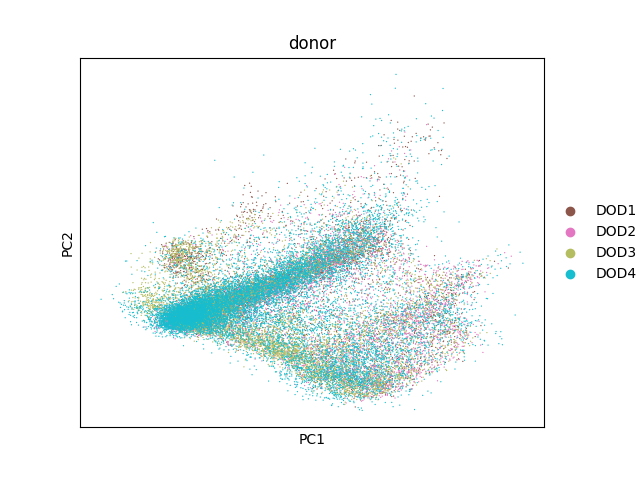

In [28]:
HTML(perma_plot())

In [29]:
%%time
umap_ref = cp.quick_umap(ref, rep_n_components=30)

CPU times: user 34.4 s, sys: 1.32 s, total: 35.7 s
Wall time: 30.9 s


Stick the 'quick umap' embedding into the ref adata to check it out

In [30]:
ref.obsm['X_Qumap'] = umap_ref.embedding_.copy()

In [31]:
sc.pl.embedding(ref, basis='Qumap', color='annot')
plt.subplots_adjust(right=0.60)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …


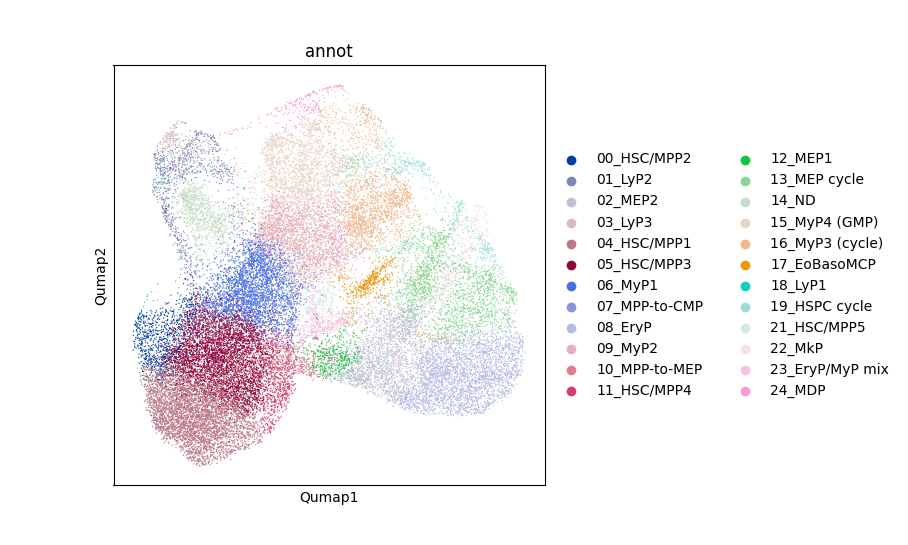

In [33]:
HTML(perma_plot())

In [34]:
%%time
cp.project_cells(target_hca,
                  ref,
                  pca_n_components=None,
                  k=15,
                  obs_columns=['annot'],
                  fit_pca=True,
                  scale_data=True,
                  use_vargenes=False,
                  #umap_ref=umap_ref,
                  numeric_fun=np.mean,
                  categorical_how='mode',
                  copy=False)

Running a common scaling for target and reference data
Fitting target data (.X) into reference PC space
Using existing PCA rotation in .varm["PCs"]
No valid UMAP object provided, UMAP parameters left unmodified
CPU times: user 26.4 s, sys: 1.35 s, total: 27.7 s
Wall time: 27.8 s


In [82]:
sc.tl.umap(target_hca)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)


In [107]:
sc.pl.embedding(target_hca, basis='umap', color=['manton', 'ref_annot'], wspace=0.1, legend_loc='on data')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …


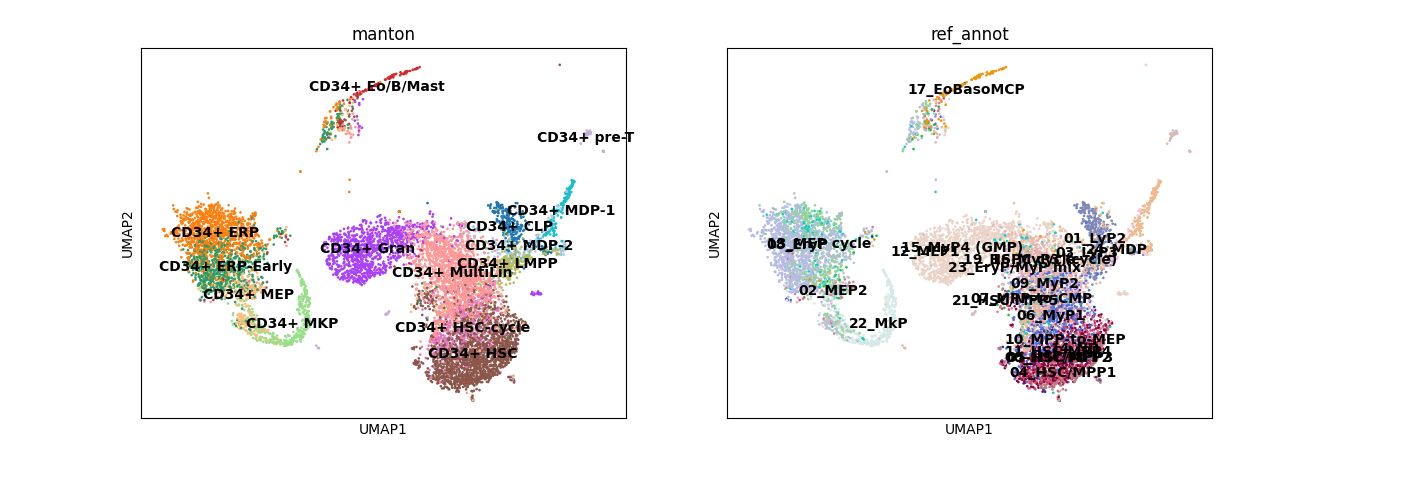

In [108]:
HTML(perma_plot())